In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import os
from SGD.dynamics import Trainer
from SGD.data import DataGenerator , SpikeGenerator
from SGD.plot_config import *
from SGD.utils import initialize_weights , velocity_field
from SGD.functions import activations
import matplotlib.pyplot as plt
import pickle   
apply_general_styles()

# Test spike model

In [42]:
# Parameters
d = 50
snr = 0.9
f_spike = 0.5
N_walkers = 5
dataset_size = None
p_repeat = None
mode = 'online'

#
teacher = 'He4'
noise = 0.0
student = 'tanh'
loss = 'mse'
k = 4
lr = 0.01*d**(-0.5*k+1)
N_steps = 50*d**(k-1)


# Initialize weights
u_spike, w_initial = initialize_weights(d, N_walkers=N_walkers, m0=0, mode='fixed')


# Initialize data generator
data_generator = SpikeGenerator(d,u_spike,snr,f_spike=f_spike,N_walkers=N_walkers,dataset_size=dataset_size,p_repeat=p_repeat,mode=mode)

# Initialize DataGenerator
# data_generator = DataGenerator(d, teacher, u_spike, noise=noise, N_walkers=N_walkers, dataset_size=dataset_size, p_repeat=p_repeat,mode=mode)

# Initialize Trainer
trainer = Trainer(d, u_spike, student, loss, lr, data_generator,N_walkers=N_walkers)

In [43]:
# Save data
tprints = np.unique(np.logspace(0,np.log10(N_steps),1000).astype(int))
data = {
    'overlap':[],
    'times':[],
}

# Run evolution
print("Starting training...")
for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True,data_init=None)):
    condition_save = step in tprints or step == N_steps - 1 or step == 0
    
    if condition_save:
        data['overlap'].append(w_student @ u_spike)
        data['times'].append(step)

    condition_print = False
    if condition_print:
        print(f"Step {step + 1}/{N_steps}: overlap = {np.dot(u_spike, w_student):.4f} ")
        
print("End training...")

for key in data:
    data[key] = np.array(data[key])
    print(f"{key} shape: {data[key].shape}")

Starting training...


100%|██████████| 6250000/6250000 [14:52<00:00, 7002.06it/s]

End training...
overlap shape: (798, 5)
times shape: (798,)


In [ ]:
def create_fig(nrows=1,ncols=1,size='single',w=1.0,h=0.5,layout='constrained',sharex=True,sharey=None):
    width = single_w if size=='single' else double_w
    figsize = (w*width,h*width)
    fig , axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,layout=layout,sharex=sharex,sharey=sharey)
    return fig , axes



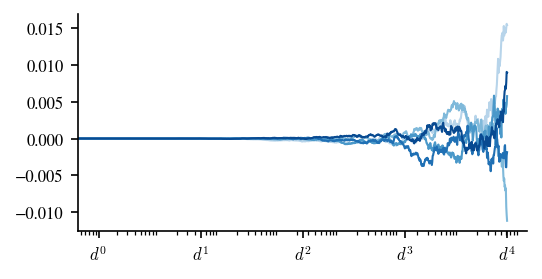

In [44]:
set_font_sizes('normal')

colors = plt.get_cmap(pc_cmaps[2])(np.linspace(0.3,0.9,N_walkers))

xtk = [d**i for i in range(k+1)]
xlb = [rf'$d^{i}$' for i in range(k+1)]

fig , axes = create_fig()

# Config
ax = axes
ax.set_xscale('log')
ax.set_xticks(xtk,xlb)
# ax.set_ylim(0,1)
# Plot
m = data['overlap']
T = data['times']
for w in range(N_walkers):
    ax.plot(T,m[:,w],color=colors[w],lw=1)

fig.savefig(fname='../logs/spike.png',bbox_inches='tight',dpi=200)

# Plot results

In [33]:
alpha = d**(k-2)*np.log(d)**2
# print(lr)
alpha**(-3/4)


np.float64(0.00010118857348692586)

# Extras

In [18]:
X , Y = data_generator.get_dataset()
print(X.shape,Y.shape)
mask = np.where(Y==1)[0]
X_spiked = X[np.where(Y==1)]
X_gauss = X[np.where(Y==-1)]
# print(Y)
print(X_spiked.shape,X_gauss.shape)

(20000, 1000) (20000,)
(9958, 1000) (10042, 1000)


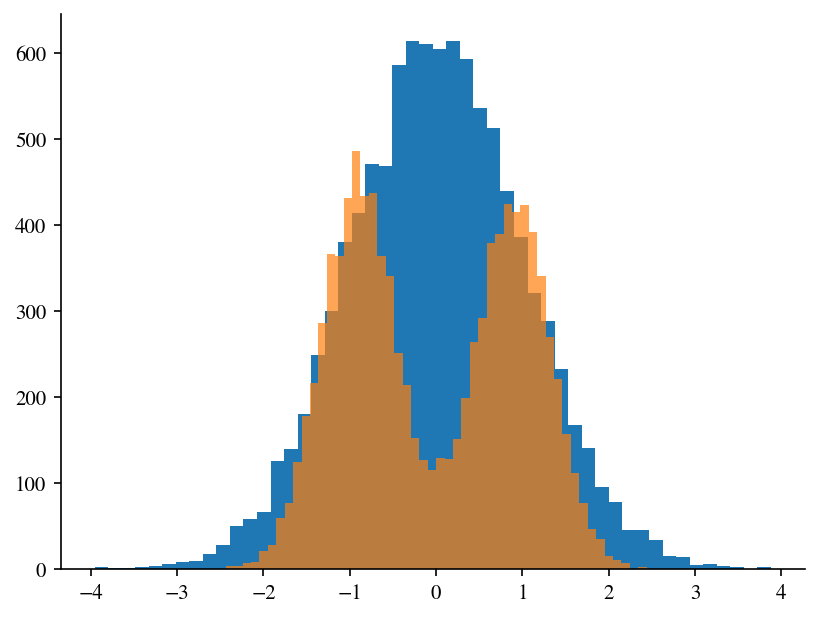

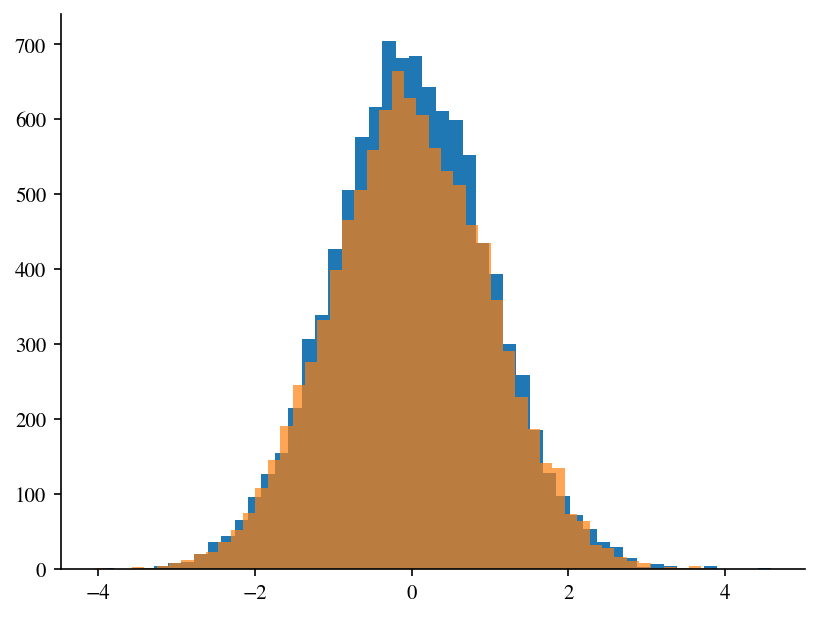

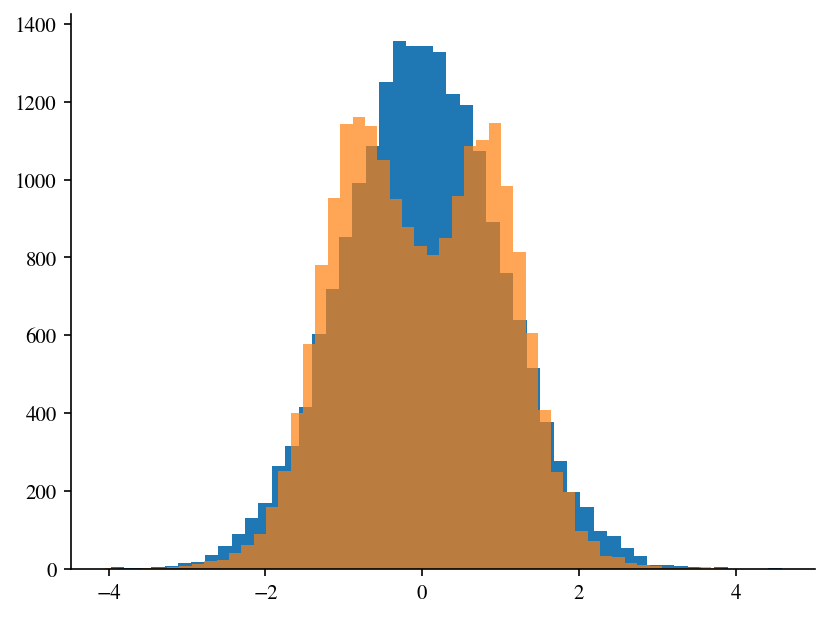

In [19]:
plt.hist(X_spiked[:,1],bins=50)
plt.hist(X_spiked[:,0],bins=50,alpha=.7)
plt.show()

plt.hist(X_gauss[:,1],bins=50)
plt.hist(X_gauss[:,0],bins=50,alpha=.7)
plt.show()

plt.hist(X[:,1],bins=50)
plt.hist(X[:,0],bins=50,alpha=.7)
plt.show()

(10042, 1000) (1000, 1000) (1000,)


(array([15., 23., 27., 31., 32., 35., 34., 34., 36., 36., 36., 32., 33.,
        34., 33., 32., 32., 29., 32., 28., 28., 28., 26., 26., 26., 24.,
        24., 21., 21., 21., 18., 18., 16., 15., 14., 15., 11.,  9.,  8.,
         7.]),
 array([0.46968442, 0.50088694, 0.53208946, 0.56329198, 0.5944945 ,
        0.62569702, 0.65689954, 0.68810206, 0.71930458, 0.7505071 ,
        0.78170962, 0.81291215, 0.84411467, 0.87531719, 0.90651971,
        0.93772223, 0.96892475, 1.00012727, 1.03132979, 1.06253231,
        1.09373483, 1.12493735, 1.15613987, 1.1873424 , 1.21854492,
        1.24974744, 1.28094996, 1.31215248, 1.343355  , 1.37455752,
        1.40576004, 1.43696256, 1.46816508, 1.4993676 , 1.53057012,
        1.56177265, 1.59297517, 1.62417769, 1.65538021, 1.68658273,
        1.71778525]),
 <BarContainer object of 40 artists>)

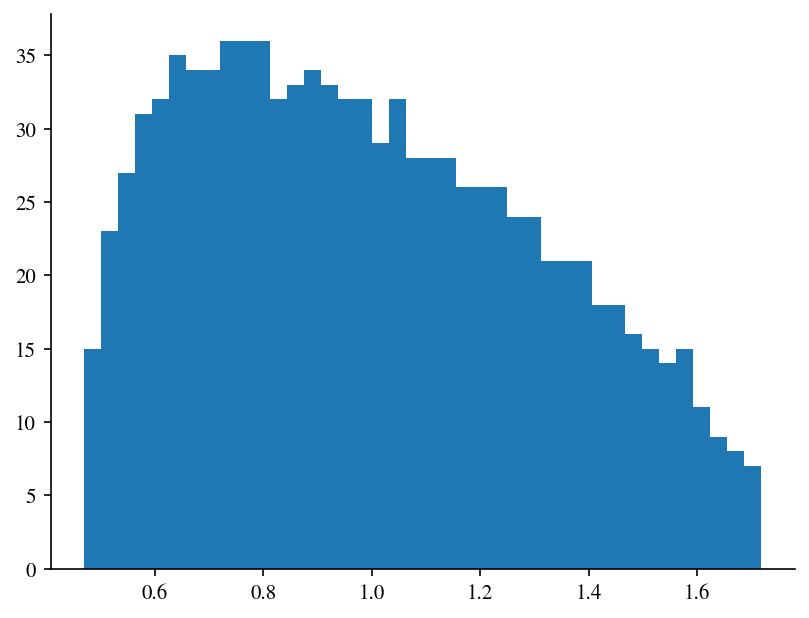

In [35]:
Z = X_gauss
C = Z.T @ Z / len(Z)
vals = np.sort(np.linalg.eigvalsh(C))[::-1]
print(Z.shape,C.shape,vals.shape)
plt.hist(vals,bins=40)
# plt.plot(vals)

In [28]:
N = 1000
Ns = 10000
u=np.zeros(N)
u[0]=1
X=sample_spiked_cumulant(u,Ns,.9)
X[0,:].var()

np.float64(0.9999240387826036)

(1000, 10000) (1000, 1000) (1000,)


(array([14., 25., 27., 31., 34., 33., 34., 36., 34., 35., 36., 34., 34.,
        34., 33., 33., 31., 31., 30., 28., 28., 28., 27., 25., 27., 23.,
        24., 22., 20., 20., 20., 17., 16., 16., 14., 12., 12., 11.,  7.,
         4.]),
 array([0.46855784, 0.50006829, 0.53157874, 0.56308919, 0.59459964,
        0.62611009, 0.65762054, 0.68913099, 0.72064144, 0.75215189,
        0.78366234, 0.81517279, 0.84668324, 0.87819369, 0.90970414,
        0.94121459, 0.97272504, 1.00423549, 1.03574594, 1.06725639,
        1.09876684, 1.13027729, 1.16178774, 1.19329819, 1.22480864,
        1.25631909, 1.28782954, 1.31933999, 1.35085044, 1.38236089,
        1.41387134, 1.44538179, 1.47689224, 1.50840269, 1.53991314,
        1.57142359, 1.60293404, 1.63444449, 1.66595494, 1.69746539,
        1.72897584]),
 <BarContainer object of 40 artists>)

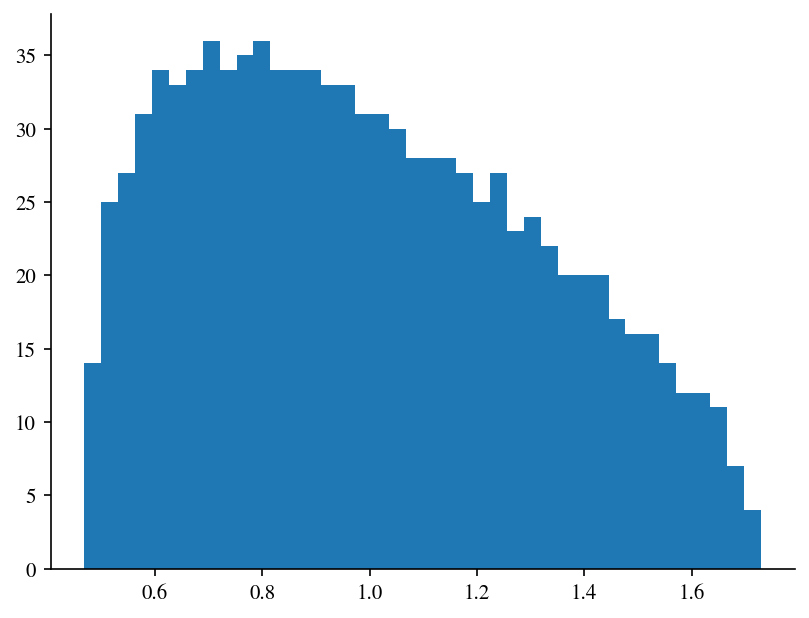

In [29]:
C = 1/Ns * X @ X.T
vals = np.sort(np.linalg.eigvalsh(C))[::-1]
print(X.shape,C.shape,vals.shape)
plt.hist(vals,bins=40)
# plt.plot(vals)

In [25]:
def sample_spiked_cumulant(spike_vector: np.ndarray, n_points: int, snr: float) -> np.ndarray:
    """
    Generate samples from a spiked covariance model.

    Parameters
    ----------
    spike_vector : np.ndarray, shape (d,)
        The d-dimensional spike direction (must be unit-norm).
    n_points : int
        Number of samples (columns) to generate.
    snr : float
        Signal-to-noise ratio in [0, 1].

    Returns
    -------
    np.ndarray
        Matrix of shape (d, n_points) containing the generated samples.

    Notes
    -----
    The model is:
        X = Z + snr * (u ⊗ h) + (sqrt(1 - snr**2) - 1) * (u uᵀ Z)
    where:
        - Z ~ N(0, I) are Gaussian noise samples,
        - h ∈ {−1, +1}^n_points are Rademacher latent variables,
        - u is the spike_vector.
    """
    # Check that spike_vector is approximately unit-norm
    norm_u = np.linalg.norm(spike_vector)
    if not np.isclose(norm_u, 1.0, atol=1e-6):
        raise ValueError(f"spike_vector must have unit norm (‖u‖ ≈ 1), got {norm_u:.6f}")

    # Basic input validation
    if not (0 <= snr <= 1):
        raise ValueError(f"SNR must be between 0 and 1, got {snr}")

    d = spike_vector.shape[0]
    x = np.random.randn(d, n_points)  # Gaussian noise
    h = np.sign(np.random.randn(n_points))  # Random ±1 signs

    # Construct spike and whitening terms
    spike_term = np.outer(spike_vector, h)
    whitening_term = spike_vector[:, None] @ (spike_vector[None, :] @ x)

    # Apply SNR and sum
    x += snr * spike_term + (np.sqrt(1 - snr**2) - 1) * whitening_term

    return x


In [32]:
N = 1000
Ns = 10000
u=np.zeros(N)
u[0]=1
X=sample_spiked_cumulant(u,Ns,.99)
X[0,:].var()

np.float64(0.9973823354275857)

(1000, 10000) (1000, 1000) (1000,)


(array([14., 23., 28., 30., 33., 34., 34., 35., 36., 33., 36., 33., 36.,
        32., 32., 33., 33., 29., 31., 28., 29., 29., 25., 28., 24., 23.,
        25., 22., 21., 20., 19., 18., 17., 15., 16., 12., 10., 10.,  7.,
         7.]),
 array([ 4.67638549,  4.99043679,  5.30448808,  5.61853937,  5.93259066,
         6.24664195,  6.56069324,  6.87474454,  7.18879583,  7.50284712,
         7.81689841,  8.1309497 ,  8.445001  ,  8.75905229,  9.07310358,
         9.38715487,  9.70120616, 10.01525745, 10.32930875, 10.64336004,
        10.95741133, 11.27146262, 11.58551391, 11.89956521, 12.2136165 ,
        12.52766779, 12.84171908, 13.15577037, 13.46982166, 13.78387296,
        14.09792425, 14.41197554, 14.72602683, 15.04007812, 15.35412941,
        15.66818071, 15.982232  , 16.29628329, 16.61033458, 16.92438587,
        17.23843717]),
 <BarContainer object of 40 artists>)

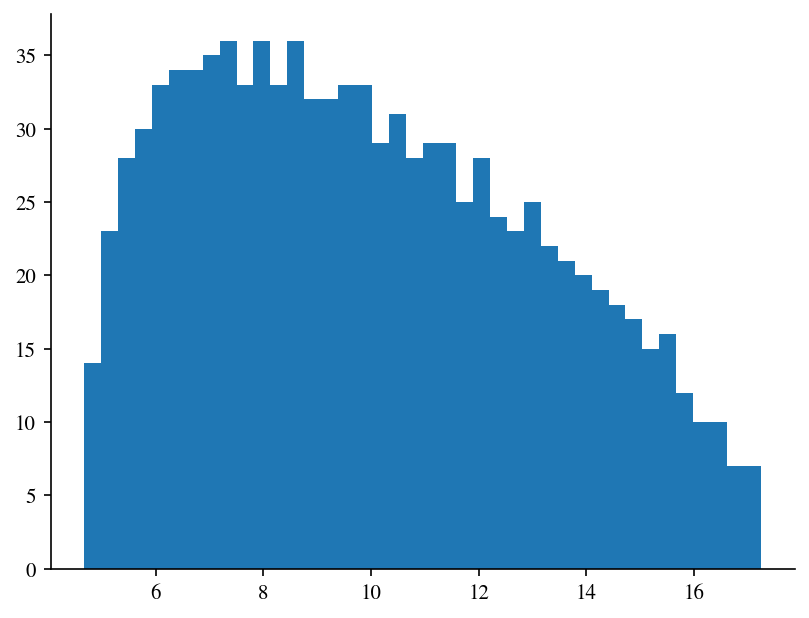

In [33]:
C = 1/N * X @ X.T
vals = np.sort(np.linalg.eigvalsh(C))[::-1]
print(X.shape,C.shape,vals.shape)
plt.hist(vals,bins=40)
# plt.plot(vals)

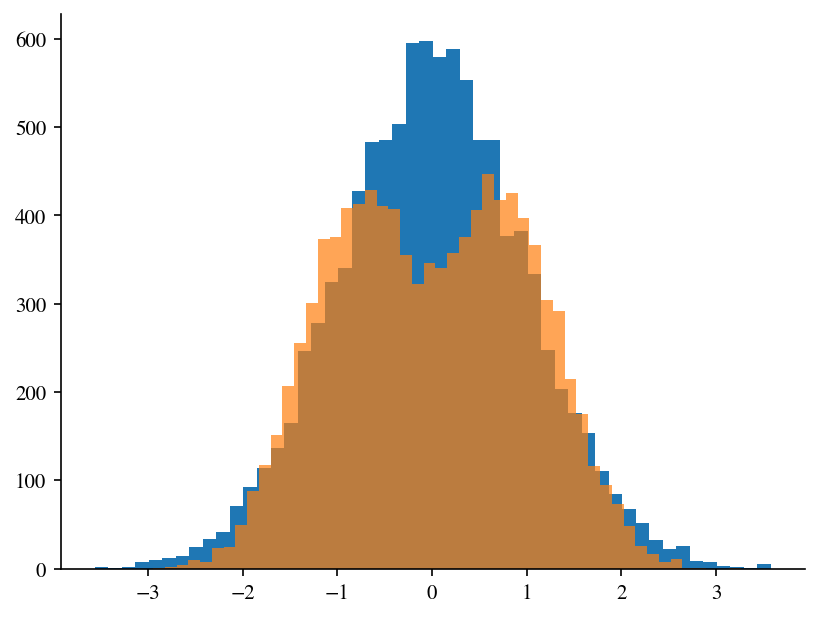

In [28]:
plt.hist(X[1,:],bins=50)
plt.hist(X[0,:],bins=50,alpha=.7)
plt.show()

# Run SGD

In [46]:
d = 100
N_walkers = 3
teacher = "He3"
student = "tanh"
loss = "mse"
# lr = 0.001/d**2
w_teacher = np.random.randn(d)
w_teacher/=np.linalg.norm(w_teacher)
w_initial = np.random.randn(d)
w_initial/=np.linalg.norm(w_initial)
w_initial -= w_teacher * (w_initial @ w_teacher)
w_initial /= np.linalg.norm(w_initial)
w_initial = w_teacher*(1/np.sqrt(d)) + w_initial * np.sqrt((d-1)/d)

noise = 0.0
dataset_size = 5
p_repeat = 0.001



alpha = 0.1
lr = 5/d
N_steps = int(alpha*d)
print(f'N_steps = {N_steps}, lr = {lr:.2e}')
print(f"lr * d^2 = {lr * d*d:.2e}")

N_steps = 10, lr = 5.00e-02
lr * d^2 = 5.00e+02


In [47]:
# Initialize DataGenerator
data_generator = DataGenerator(d, teacher, w_teacher, noise=noise, dataset_size=dataset_size, p_repeat=p_repeat,mode='repeat')

# Extract Data as arrays
X , Y = data_generator.get_dataset(how='arrays')
data_init = (X[0],Y[0])

print(f"Data shape: X = {X.shape} , Y = {Y.shape}" )

# Initialize Trainer
trainer = Trainer(d, w_teacher, teacher, student, loss, lr, data_generator)

# Save data
data = {
    'overlap':[],
    'preactivations':[],
    'flags':[],
    'times':[],
    'grad':[],
    'ov_grad':[]
}
# Run evolution
print("Starting training...")
for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True,data_init=data_init)):
    condition_save = step % 1 == 0 or step == N_steps - 1 or flag != 0
    
    if condition_save:
        data['overlap'].append(np.dot(w_teacher, w_student))
        data['preactivations'].append(X @ w_student)
        data['flags'].append(flag)
        data['times'].append(step)
        data['grad'].append(np.linalg.norm(grad))
        data['ov_grad'].append(X @ grad)

    # condition = step % 100 == 0 or step == N_steps - 1
    condition = False
    if condition:
        print(f"Step {step + 1}/{N_steps}: overlap = {np.dot(w_teacher, w_student):.4f} : flag = {flag} : preactivations = {X @ w_student} ")
print("End training...")

for key in data:
    data[key] = np.array(data[key])
    print(f"{key} shape: {data[key].shape}")

Data shape: X = (5, 100) , Y = (5,)
Starting training...


100%|██████████| 10/10 [00:00<00:00, 2021.64it/s]

End training...
overlap shape: (10,)
preactivations shape: (10, 5)
flags shape: (10,)
times shape: (10,)
grad shape: (10,)
ov_grad shape: (10, 5)
